## **Implementation of the Vision Transformer**

### **Importing necessary libraries**

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

### **DataPreprocessing : Loading the data in batches using dataloader and applying the transformation of converting the input images to PyTorch tensors and printing the dataset information**

In [ ]:
# Define the transformation that converts the image to tensor and normalizes it
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR10 dataset and apply the transformation
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)

# Print some information about the datasets
print(f'Training dataset size: {len(train_set)}')
print(f'Test dataset size: {len(test_set)}')
print(f'Classes: {train_set.classes}')

Training dataset size: 60000
Test dataset size: 10000
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


### **Checking the first batch of images and labels from the trainloader**

Images shape: torch.Size([20, 1, 28, 28])
Labels shape: torch.Size([20])


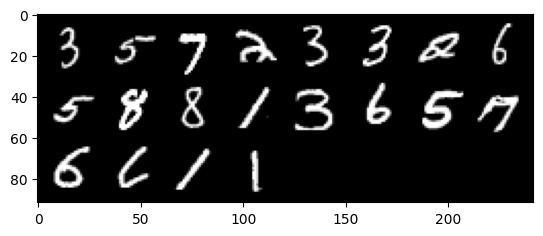

In [ ]:
for images, labels in trainloader:
    break

# Display a grid of images
grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

# Print the shapes of the images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


### **Function to divide the input images into patches**

In [ ]:
def split_image_into_patches(images, patch_size):
    batch_size, num_channels, height, width = images.shape
    num_vert_patches = height // patch_size
    num_horiz_patches = width // patch_size
    
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.reshape(batch_size, num_channels, num_vert_patches*num_horiz_patches, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    patches = patches.reshape(batch_size, num_vert_patches*num_horiz_patches, num_channels*patch_size*patch_size)
    
    return patches

### **Displaying an image that is divided into patches along with the original image**

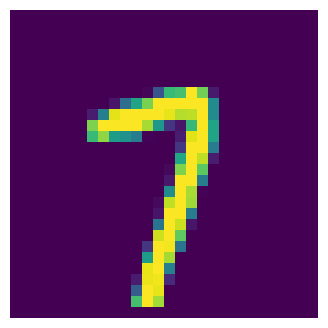

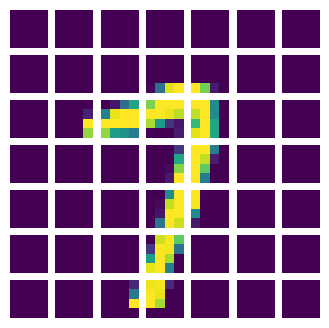

In [ ]:
# Get one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Get one image from the batch
image = images[0]

# Split the image into patches
patches = split_image_into_patches(image.unsqueeze(0), 4)

# Calculate the number of patches in each dimension to create a 7x7 grid of 4x4 patches
num_patches = patches.shape[1]
num_cols = 7
num_rows = 7

# Display the original image
plt.figure(figsize=(4,4))
plt.imshow(np.moveaxis(image.numpy(), 0, -1))
plt.axis('off')
plt.show()


# Display the patches in a 7x7 grid of 4x4 patches
plt.figure(figsize=(4,4))
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i*num_cols+j+1)
        plt.imshow(np.transpose(patches[0, i*num_cols+j].reshape(1,4,4), (1,2,0)))
        plt.axis('off')
plt.show()

### **Function that takes the flattened patches and projects it to the embedding dimension**

In [ ]:
def embed_patches(patches, embedding_dim):
  
    # Define the linear embedding layer
    embed_layer = nn.Linear(in_features=patches.shape[-1], out_features=embedding_dim)

    # Apply the embedding layer to the flattened tensor
    embed_patches = embed_layer(patches)  # shape: [num_images * num_patches, embedding_dim]

    return embed_patches

### **Function to add the positional encoding to the embedding patches**

In [ ]:
def get_position_encoding(embeddings):
    num_images, num_patches, embedding_dim = embeddings.shape
    seq_length = num_patches * num_images
    num_patches = num_patches
    num_images = num_images

    pos_encoding = torch.zeros(seq_length, embedding_dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float) * (-math.log(10000.0) / embedding_dim))
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    pos_encoding = pos_encoding[:num_patches, :].unsqueeze(0).repeat(num_images, 1, 1)
    pos_encoding = pos_encoding.reshape(-1, pos_encoding.size(-1))
    pos_encoding = pos_encoding.view(num_images, num_patches, embedding_dim)

    return pos_encoding

### **Encoder block function with Multi-head attention and the fully connected network**

In [ ]:
# Define the Encoder block with multi-head attention
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 6*embed_dim),
            nn.GELU(),
            nn.Linear(6*embed_dim, embed_dim)
        )

    def forward(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Multi-head attention with residual connection
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_output

        # Layer normalization
        x_norm = self.norm2(x)

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x_norm)
        x = x + ffn_output

        return x


### **MLP Classifer Head**

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc3(out)
        return out

### **Implementation of the ViT Model**

In [ ]:
class ViT(nn.Module):

    def __init__(self, inputs, patch_size, embed_dim, input_size, num_heads, hidden_dim, num_classes, device):
        super(ViT, self).__init__()

        self.inputs = inputs
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.device = device

        self.class_token = nn.Parameter(torch.rand(1, self.embed_dim))

        # self.encoder_block = EncoderBlock(self.hidden_dim, self.num_heads)
        encoder_blocks = []
        for i in range(2):
            encoder_blocks.append(EncoderBlock(self.embed_dim, self.num_heads))
        self.encoder_block = nn.Sequential(*encoder_blocks)

        self.mlp_head = MLPClassifier(self.input_size, self.hidden_dim, self.num_classes)
       
    def forward(self, inputs):

        patches = split_image_into_patches(inputs, self.patch_size)

        embed_layer = embed_patches(patches, self.embed_dim)
        tokens = torch.stack([torch.vstack((self.class_token, embed_layer[i])) for i in range(len(embed_layer))])
        
        pos_encoding = get_position_encoding(tokens)
        
        embeddings = tokens + pos_encoding


        # Apply Encoder block to input in batches
        encoded_sequence = self.encoder_block(embeddings)



        encoded_output = encoded_sequence.flatten(1)


        # Pass through MLP
        mlp_output = self.mlp_head(encoded_output)

        return mlp_output


In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize ViT model
vit_model = ViT(inputs = (1,28,28), patch_size = 4, embed_dim = 8, input_size = 400, num_heads = 2, hidden_dim = 128, num_classes = 10, device = device)

# move model to device
vit_model

ViT(
  (encoder_block): Sequential(
    (0): EncoderBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=8, out_features=48, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=48, out_features=8, bias=True)
      )
    )
    (1): EncoderBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=8, out_features=48, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=48, out_features=8,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        # data, target = data.to(device), target.to(device)

        # Forward pass
        outputs = vit_model(data)
        loss = criterion(outputs, target)

        # Backward pass and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if batch_idx % 100 == 99: # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}: Loss {running_loss / 100:.3f}')
            running_loss = 0.0

with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Epoch 1, Batch 100: Loss 2.313
Epoch 1, Batch 200: Loss 2.294
Epoch 1, Batch 300: Loss 2.021
Epoch 1, Batch 400: Loss 1.365
Epoch 1, Batch 500: Loss 1.082
Epoch 1, Batch 600: Loss 1.067
Epoch 1, Batch 700: Loss 0.889
Epoch 1, Batch 800: Loss 0.895
Epoch 1, Batch 900: Loss 0.799
Epoch 1, Batch 1000: Loss 0.815
Epoch 1, Batch 1100: Loss 0.815
Epoch 1, Batch 1200: Loss 0.792
Epoch 1, Batch 1300: Loss 0.683
Epoch 1, Batch 1400: Loss 0.704
Epoch 1, Batch 1500: Loss 0.640
Epoch 1, Batch 1600: Loss 0.614
Epoch 1, Batch 1700: Loss 0.607
Epoch 1, Batch 1800: Loss 0.668
Epoch 1, Batch 1900: Loss 0.639
Epoch 1, Batch 2000: Loss 0.590
Epoch 1, Batch 2100: Loss 0.566
Epoch 1, Batch 2200: Loss 0.587
Epoch 1, Batch 2300: Loss 0.642
Epoch 1, Batch 2400: Loss 0.500
Epoch 1, Batch 2500: Loss 0.584
Epoch 1, Batch 2600: Loss 0.507
Epoch 1, Batch 2700: Loss 0.502
Epoch 1, Batch 2800: Loss 0.490
Epoch 1, Batch 2900: Loss 0.536
Epoch 1, Batch 3000: Loss 0.485
Epoch 2, Batch 100: Loss 0.479
Epoch 2, Batch 200

Testing: 100%|██████████| 500/500 [00:04<00:00, 101.47it/s]

Test loss: 0.29
Test accuracy: 90.28%


In [ ]:
path = './model_mnist_10.pt'

torch.save({
        'epoch': epoch,
        'model_state_dict': vit_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, path)

In [ ]:
checkpoint = torch.load(path)
vit_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
for epoch in range(curr_epoch+1,15):
  running_loss = 0.0
  for batch_idx, (data, target) in enumerate(trainloader):
      # data, target = data.to(device), target.to(device)

      # Forward pass
      outputs = vit_model(data)
      loss = criterion(outputs, target)

      # Backward pass and update parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # Print statistics
      if batch_idx % 100 == 99: # print every 100 mini-batches
          print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}: Loss {running_loss / 100:.3f}')
          running_loss = 0.0


with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        # x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")



Epoch 12, Batch 100: Loss 0.287
Epoch 12, Batch 200: Loss 0.218
Epoch 12, Batch 300: Loss 0.249
Epoch 12, Batch 400: Loss 0.257
Epoch 12, Batch 500: Loss 0.278
Epoch 12, Batch 600: Loss 0.271
Epoch 12, Batch 700: Loss 0.252
Epoch 12, Batch 800: Loss 0.263
Epoch 12, Batch 900: Loss 0.277
Epoch 12, Batch 1000: Loss 0.295
Epoch 12, Batch 1100: Loss 0.270
Epoch 12, Batch 1200: Loss 0.245
Epoch 12, Batch 1300: Loss 0.291
Epoch 12, Batch 1400: Loss 0.284
Epoch 12, Batch 1500: Loss 0.287
Epoch 12, Batch 1600: Loss 0.307
Epoch 12, Batch 1700: Loss 0.282
Epoch 12, Batch 1800: Loss 0.268
Epoch 12, Batch 1900: Loss 0.302
Epoch 12, Batch 2000: Loss 0.279
Epoch 12, Batch 2100: Loss 0.301
Epoch 12, Batch 2200: Loss 0.254
Epoch 12, Batch 2300: Loss 0.287
Epoch 12, Batch 2400: Loss 0.251
Epoch 12, Batch 2500: Loss 0.279
Epoch 12, Batch 2600: Loss 0.274
Epoch 12, Batch 2700: Loss 0.294
Epoch 12, Batch 2800: Loss 0.262
Epoch 12, Batch 2900: Loss 0.314
Epoch 12, Batch 3000: Loss 0.288
Epoch 13, Batch 100

Testing: 100%|██████████| 500/500 [00:04<00:00, 122.00it/s]

Test loss: 0.27
Test accuracy: 91.18%


In [ ]:
path = './model_mnist_15.pt'

torch.save({
        'epoch': epoch,
        'model_state_dict': vit_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, path)

In [ ]:
checkpoint = torch.load(path)
vit_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
for epoch in range(curr_epoch+1,20):
  running_loss = 0.0
  for batch_idx, (data, target) in enumerate(trainloader):
      # data, target = data.to(device), target.to(device)

      # Forward pass
      outputs = vit_model(data)
      loss = criterion(outputs, target)

      # Backward pass and update parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # Print statistics
      if batch_idx % 100 == 99: # print every 100 mini-batches
          print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}: Loss {running_loss / 100:.3f}')
          running_loss = 0.0


with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        # x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")



Epoch 16, Batch 100: Loss 0.250
Epoch 16, Batch 200: Loss 0.255
Epoch 16, Batch 300: Loss 0.276
Epoch 16, Batch 400: Loss 0.285
Epoch 16, Batch 500: Loss 0.238
Epoch 16, Batch 600: Loss 0.262
Epoch 16, Batch 700: Loss 0.267
Epoch 16, Batch 800: Loss 0.265
Epoch 16, Batch 900: Loss 0.247
Epoch 16, Batch 1000: Loss 0.263
Epoch 16, Batch 1100: Loss 0.229
Epoch 16, Batch 1200: Loss 0.260
Epoch 16, Batch 1300: Loss 0.250
Epoch 16, Batch 1400: Loss 0.297
Epoch 16, Batch 1500: Loss 0.224
Epoch 16, Batch 1600: Loss 0.242
Epoch 16, Batch 1700: Loss 0.260
Epoch 16, Batch 1800: Loss 0.242
Epoch 16, Batch 1900: Loss 0.278
Epoch 16, Batch 2000: Loss 0.249
Epoch 16, Batch 2100: Loss 0.280
Epoch 16, Batch 2200: Loss 0.226
Epoch 16, Batch 2300: Loss 0.227
Epoch 16, Batch 2400: Loss 0.280
Epoch 16, Batch 2500: Loss 0.252
Epoch 16, Batch 2600: Loss 0.256
Epoch 16, Batch 2700: Loss 0.253
Epoch 16, Batch 2800: Loss 0.213
Epoch 16, Batch 2900: Loss 0.246
Epoch 16, Batch 3000: Loss 0.278
Epoch 17, Batch 100

Testing: 100%|██████████| 500/500 [00:04<00:00, 119.36it/s]

Test loss: 0.26
Test accuracy: 91.47%


In [ ]:
path = './model_mnist_20.pt'

torch.save({
        'epoch': epoch,
        'model_state_dict': vit_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, path)

### **Model Evaluation**

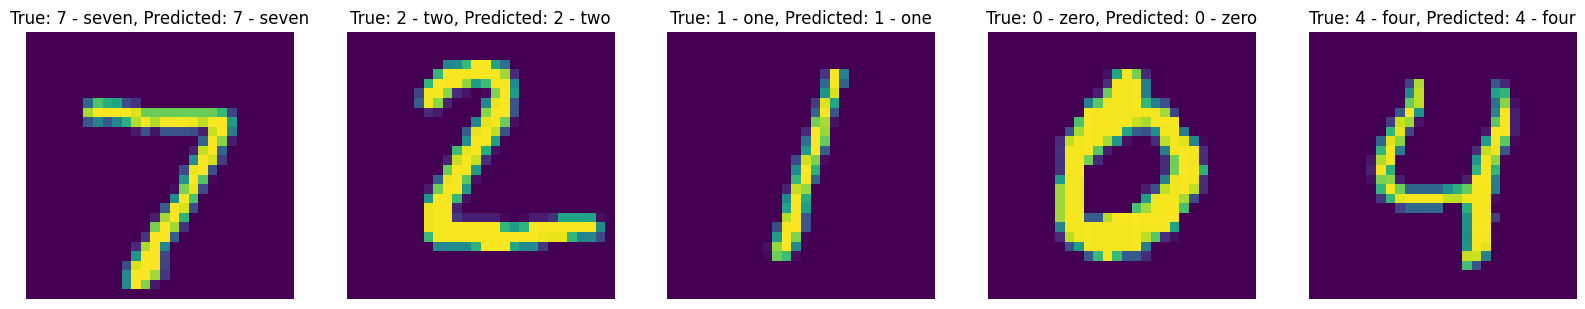

In [ ]:
# set the model to evaluation mode
vit_model.eval()

class_names = train_set.classes

# get a few random test images
test_dataiter = iter(testloader)
images, labels = next(test_dataiter)

# make predictions on the test images
with torch.no_grad():
    outputs = vit_model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()

# map the labels to their corresponding class names
true_labels = [class_names[label] for label in labels]
predicted_labels = [class_names[label] for label in predicted]

# plot the test images with their predicted labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    ax.axis("off")
plt.show()

### **Plotting Training vs Testing accuracy**

Epoch 0: Training Loss: 0.933, Training Accuracy: 0.676
Epoch 0: Testing Loss: 0.464, Testing Accuracy: 0.846
Epoch 1: Training Loss: 0.426, Training Accuracy: 0.857
Epoch 1: Testing Loss: 0.376, Testing Accuracy: 0.873
Epoch 2: Training Loss: 0.360, Training Accuracy: 0.880
Epoch 2: Testing Loss: 0.341, Testing Accuracy: 0.888
Epoch 3: Training Loss: 0.330, Training Accuracy: 0.889
Epoch 3: Testing Loss: 0.333, Testing Accuracy: 0.888
Epoch 4: Training Loss: 0.304, Training Accuracy: 0.898
Epoch 4: Testing Loss: 0.317, Testing Accuracy: 0.897
Epoch 5: Training Loss: 0.295, Training Accuracy: 0.903
Epoch 5: Testing Loss: 0.289, Testing Accuracy: 0.901
Epoch 6: Training Loss: 0.285, Training Accuracy: 0.905
Epoch 6: Testing Loss: 0.278, Testing Accuracy: 0.907
Epoch 7: Training Loss: 0.273, Training Accuracy: 0.909
Epoch 7: Testing Loss: 0.277, Testing Accuracy: 0.909
Epoch 8: Training Loss: 0.269, Training Accuracy: 0.909
Epoch 8: Testing Loss: 0.278, Testing Accuracy: 0.908
Epoch 9: T

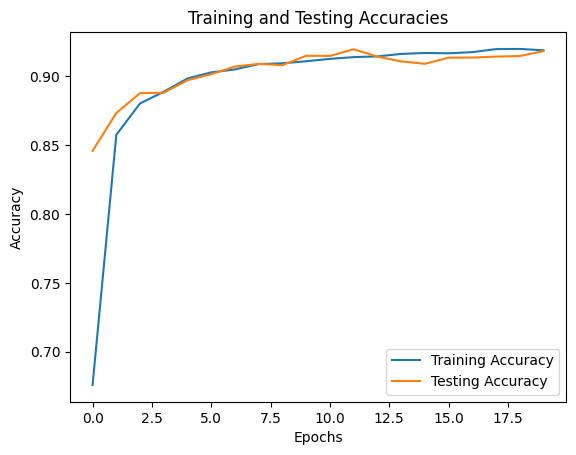

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

num_epochs = 20


for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for batch_idx, (data, target) in enumerate(trainloader):
        outputs = vit_model(data)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # compute training accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

    # compute training loss and accuracy for this epoch
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = correct / total
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    print(f'Epoch {epoch}: Training Loss: {epoch_train_loss:.3f}, Training Accuracy: {epoch_train_acc:.3f}')

    # evaluate on the test set
    correct, total = 0, 0
    test_epoch_loss = 0.0
    with torch.no_grad():
        for data, target in testloader:
            outputs = vit_model(data)
            loss = criterion(outputs, target)
            test_epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    # compute test loss and accuracy for this epoch
    epoch_test_loss = test_epoch_loss / len(testloader)
    epoch_test_acc = correct / total
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    print(f'Epoch {epoch}: Testing Loss: {epoch_test_loss:.3f}, Testing Accuracy: {epoch_test_acc:.3f}')

# plot the training and testing accuracies for each epoch
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), test_acc, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.show()


### **This below code is used for testing Top-2 and Top-3 accuracies with average error rates**

In [ ]:
# ## Top 2 and 3 accuracy with error
# with torch.no_grad():
#     correct2, total2 = 0, 0
#     correct3, total3 = 0, 0
#     test_loss = 0.0
#     total_error2 = 0.0
#     total_error3 = 0.0
#     total_imgs_top2 = 0 
#     total_imgs_top3 = 0 
#     for batch in tqdm(testloader, desc="Testing"):
#         x, y = batch
#         y_hat = vit_model(x)
#         y_hat_norm = F.softmax(y_hat, dim=1)
#         loss = criterion(y_hat, y)
#         test_loss += loss.detach().cpu().item() / len(testloader)

#         top2_vals,top2_inds = torch.topk(y_hat_norm, k = 2, dim = 1)
#         top_vals = top2_vals[:,0]
#         correct2 += torch.sum(top2_inds[:, 0] == y).detach().cpu().item() + torch.sum(top2_inds[:, 1] == y).detach().cpu().item()
#         total2 += len(x)

#         # Calculate error rate for cases where the second highest probability is the correct prediction
#         for i in range(len(y)):
#             if top2_inds[i][0] != y[i] and top2_inds[i][1] == y[i]:
#                 #print(top2_vals[i][0] - top2_vals[i][1])
#                 total_error2 += top2_vals[i][0] - top2_vals[i][1]
#                 total_imgs_top2+=1
        
#         top3_vals,top3_inds = torch.topk(y_hat_norm, k = 3, dim = 1)
#         top_vals = top3_vals[:,0]
#         correct3 += torch.sum(top3_inds[:, 0] == y).detach().cpu().item() + torch.sum(top3_inds[:, 1] == y).detach().cpu().item() + torch.sum(top3_inds[:, 2] == y).detach().cpu().item()
#         total3 += len(x)

#         # Calculate error rate for cases where the second highest probability is the correct prediction
#         for i in range(len(y)):
#             if top3_inds[i][0] != y[i] and top3_inds[i][1] == y[i]:
#                 total_error3 += top3_vals[i][0] - top3_vals[i][1]
#                 total_imgs_top3+=1
#             elif top3_inds[i][0] != y[i] and top3_inds[i][2] == y[i]:
#                 total_error3 += top3_vals[i][0] - top3_vals[i][2]
#                 total_imgs_top3+=1

#     avg_error = total_error2 / total_imgs_top2  # Only calculate error rate for cases where the 2nd highest probability is the correct prediction
#     print(f"Test loss: {test_loss:.2f}")
#     print(f"Test top-2 accuracy: {correct2 / total2 * 100:.2f}%")
#     print(f"Average error rate: {avg_error:.4f}")

#     avg_error = total_error3 / total_imgs_top3  # Only calculate error rate for cases where the 2nd highest probability is the correct prediction
#     print(f"Test top-3 accuracy: {correct3 / total3 * 100:.2f}%")
#     print(f"Average error rate: {avg_error:.4f}")